In [1]:
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot
from tensorflow.python.keras.utils.vis_utils import check_pydot


# define the discriminator model
def define_discriminator(image_shape):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # source image input
    in_src_image = Input(shape=image_shape)
    # target image input
    in_target_image = Input(shape=image_shape)
    # concatenate images channel-wise
    merged = Concatenate()([in_src_image, in_target_image])
    # C64
    d = Conv2D(64, (4, 4),
               strides=(2, 2),
               padding='same',
               kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    # C128
    d = Conv2D(128, (4, 4),
               strides=(2, 2),
               padding='same',
               kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C256
    d = Conv2D(256, (4, 4),
               strides=(2, 2),
               padding='same',
               kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C512
    d = Conv2D(512, (4, 4),
               strides=(2, 2),
               padding='same',
               kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # second last output layer
    d = Conv2D(512, (4, 4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # patch output
    d = Conv2D(1, (4, 4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    # define model
    model = Model([in_src_image, in_target_image], patch_out)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  loss_weights=[0.5])
    return model


# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add downsampling layer
    g = Conv2D(n_filters, (4, 4),
               strides=(2, 2),
               padding='same',
               kernel_initializer=init)(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g


# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add upsampling layer
    g = Conv2DTranspose(n_filters, (4, 4),
                        strides=(2, 2),
                        padding='same',
                        kernel_initializer=init)(layer_in)
    # add batch normalization
    g = BatchNormalization()(g, training=True)
    # conditionally add dropout
    if dropout:
        g = Dropout(0.5)(g, training=True)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    # relu activation
    g = Activation('relu')(g)
    return g


# define the standalone generator model
def define_generator(image_shape=(256, 256, 3)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_shape)
    # encoder model
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    # e6 = define_encoder_block(e5, 512)
    # e7 = define_encoder_block(e6, 512)
    # bottleneck, no batch norm and relu
    b = Conv2D(128, (4, 4),
               strides=(2, 2),
               padding='same',
               kernel_initializer=init)(e5)
    b = Activation('relu')(b)
    # decoder model
    # d1 = decoder_block(b, e7, 512)
    # d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(b, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)
    # output
    # g = Conv2DTranspose(, (4, 4),
    g = Conv2DTranspose(1, (4, 4),
                        strides=(2, 2),
                        padding='same',
                        kernel_initializer=init)(d7)
    out_image = Activation('tanh')(g)
    # define model
    model = Model(in_image, out_image)
    return model


# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    # define the source image
    in_src = Input(shape=image_shape)
    # connect the source image to the generator input
    gen_out = g_model(in_src)
    # connect the source input and generator output to the discriminator input
    dis_out = d_model([in_src, gen_out])
    # src image as input, generated image and classification output
    model = Model(in_src, [dis_out, gen_out])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'mae'],
                  optimizer=opt,
                  loss_weights=[1, 100])
    return model


# load and prepare training images
def load_real_samples(filename):
    # load compressed arrays
    data = load(filename)
    # unpack arrays
    X1, X2 = data['arr_0'], data['arr_1']
    # scale from [0,255] to [-1,1]
    # X1 = (X1 - 127.5) / 127.5
    # X2 = (X2 - 127.5) / 127.5
    return [X1, X2]


# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    # unpack dataset
    trainA, trainB = dataset
    # choose random instances
    ix = randint(0, trainA.shape[0], n_samples)
    # retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y


# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
    # generate fake instance
    X = g_model.predict(samples)
    # create 'fake' class labels (0)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    return X, y


# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
    # select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    # generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    # scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    # plot real source images
    SHAPE = (128, 128)
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X_realA[i].reshape(SHAPE), vmin=0, vmax=1)
    # plot generated target image
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(X_fakeB[i].reshape(SHAPE), vmin=0, vmax=1)
    # plot real target image
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples * 2 + i)
        pyplot.axis('off')
        pyplot.imshow(X_realB[i].reshape(SHAPE), vmin=0, vmax=1)
    # save plot to file
    filename1 = 'result/plot_%06d.png' % (step + 1)
    pyplot.savefig(filename1)
    # pyplot.close()
    pyplot.show()
    # save the generator model
    filename2 = 'result/model_%06d.h5' % (step + 1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))


# train pix2pix models
def train(d_model, g_model, gan_model, dataset, n_epochs=10, n_batch=2):
    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]
    # unpack dataset
    trainA, trainB = dataset
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    g_losses = []
    d_los1 = []
    d_los2 = []
    # manually enumerate epochs
    for i in range(n_steps):
        # select a batch of real samples
        [X_realA,
         X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        # generate a batch of fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        # update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        # update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        # update the generator
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        # summarize performance
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' %
              (i + 1, d_loss1, d_loss2, g_loss))
        g_losses.append(g_loss)
        d_los1.append(d_loss1)
        d_los2.append(d_loss2)
        # summarize model performance
        # if (i + 1) % (bat_per_epo * 10) == 0:
        if (i + 1) % (bat_per_epo) == 0:
            summarize_performance(i, g_model, dataset)
    return d_los1, d_los2, g_losses



In [2]:
from os.path import join, dirname,exists
from os import chdir, mkdir
chdir(join(dirname(__file__)))
if not exists('data'):
    mkdir('data')
if not exists('result'):
    mkdir('result')
src, tar = load_real_samples('data/data128.npz')
assert len(src) == len(tar)
image_shape = src.shape
src, tar = src.reshape((*image_shape, 1)), tar.reshape((*image_shape, 1))

train_ratio = 0.9
dataset_size = len(src)
train_size = int(train_ratio * dataset_size)

src_train = src[:train_size]
tar_train = tar[:train_size]
src_valid = src[train_size:]
tar_valid = tar[train_size:]


In [3]:
from random import shuffle
srctar = list(zip(src_train, tar_train))
shuffle(srctar)
src_train, tar_train = list(zip(*srctar))
import numpy as np
src_train = np.array(src_train)
tar_train = np.array(tar_train)
#[:500] # training data
# validate_dataset = dataset[500:] # validation data
print('Loaded', src_train.shape, tar_train.shape)
# define input shape based on the loaded dataset
image_shape = src_train.shape[1:]

Loaded (474, 128, 128, 1) (474, 128, 128, 1)


In [4]:
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)


In [5]:
g_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 64, 64, 64)   1088        input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_5 (LeakyReLU)       (None, 64, 64, 64)   0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 32, 32, 128)  131200      leaky_re_lu_5[0][0]              
____________________________________________________________________________________________

In [6]:
d_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 128, 128, 2)  0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   2112        concatenate[0][0]            

In [7]:
gan_model.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, 128, 128, 1)  22955265    input_4[0][0]                    
__________________________________________________________________________________________________
model (Functional)              (None, 8, 8, 1)      6964161     input_4[0][0]                    
                                                                 model_1[0][0]                    
Total params: 29,919,426
Trainable params: 22,952,321
Non-trainable params: 6,967,105
__________________________________________________________________________________________________


In [8]:
check_pydot()

True

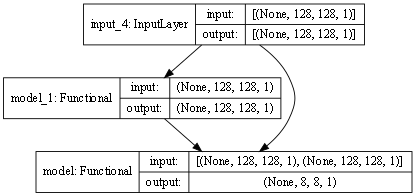

In [15]:
from keras.utils import plot_model
plot_model(gan_model,show_shapes=True, dpi=64)

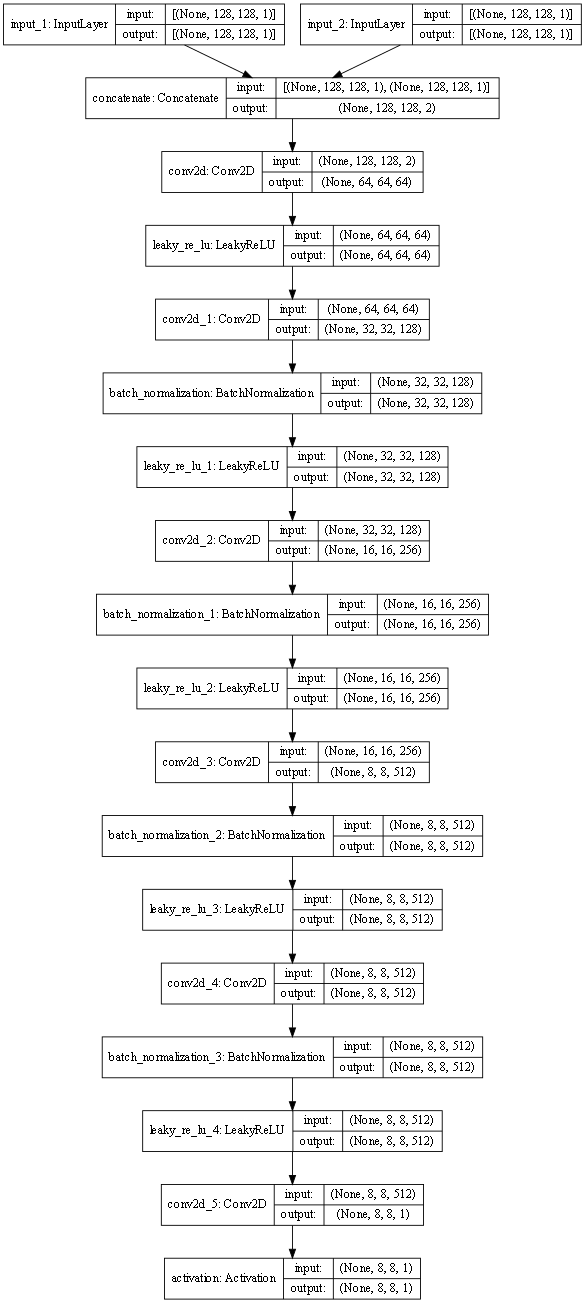

In [16]:
plot_model(d_model,show_shapes=True, dpi=64)

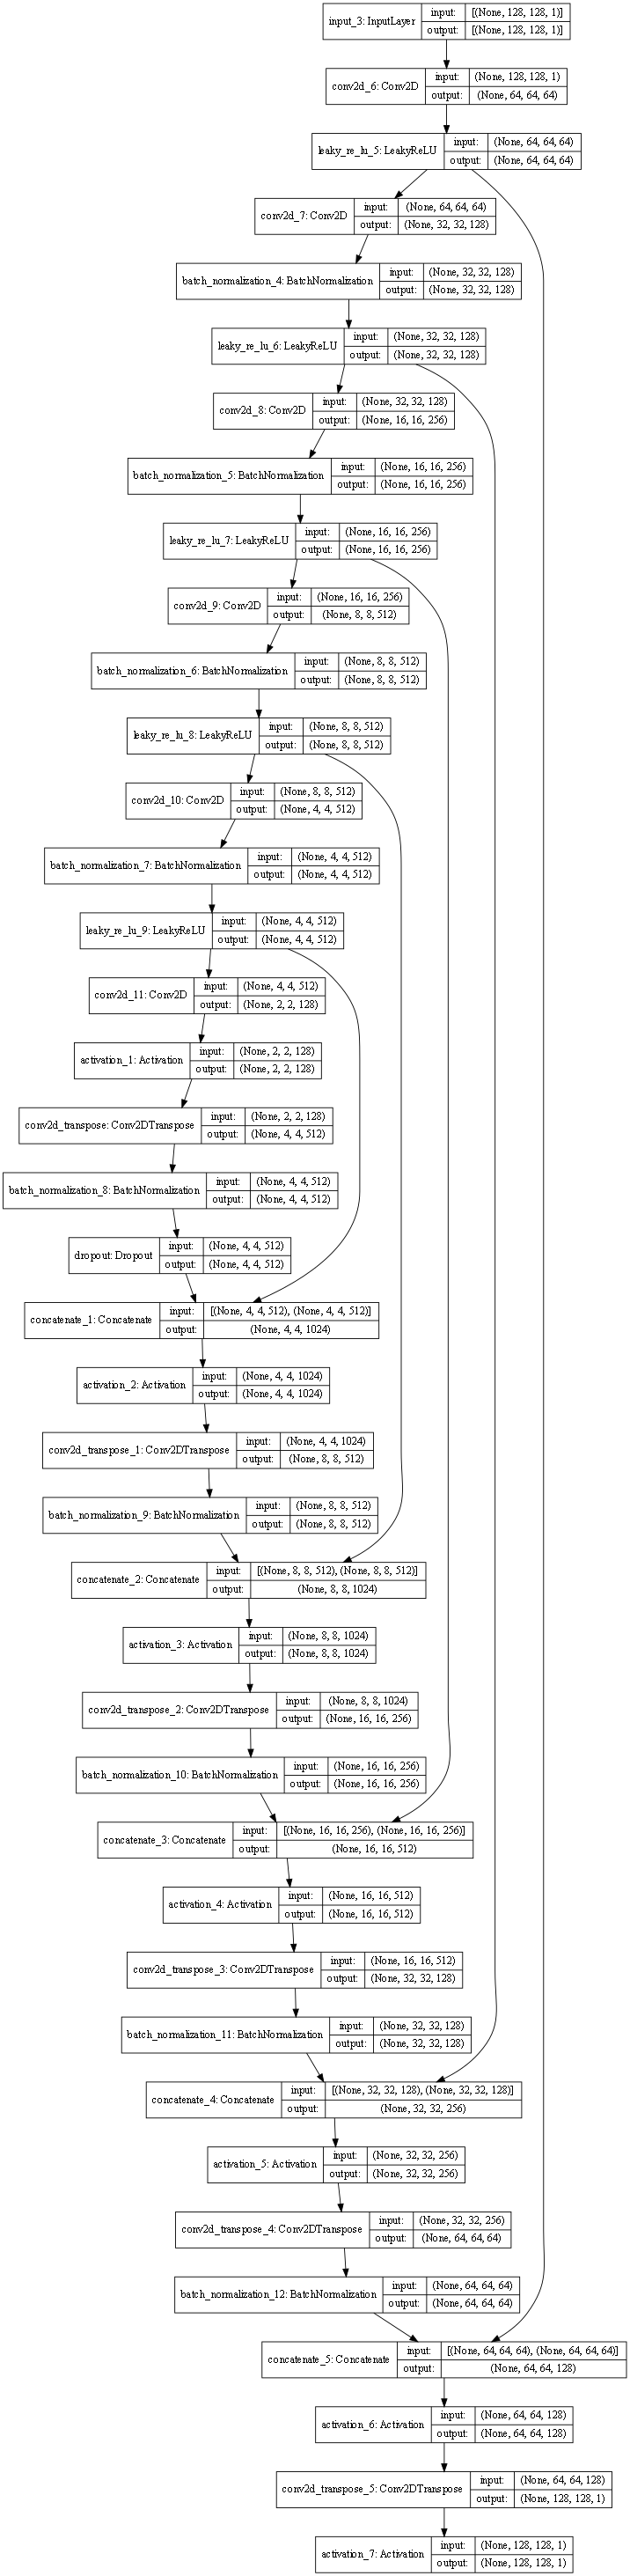

In [17]:
plot_model(g_model,show_shapes=True, dpi=64)